# **Marketing A/B-Test**

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms


In [143]:
df = pd.read_csv('marketing_AB.csv', low_memory=False)

df = df.drop(columns=['Unnamed: 0'])

df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


**Описание переменных датасета**:

1. **test group**: Тип теста, участники видели рекламу ("ad") или социальную рекламу ("psa").
2. **converted**: Индикатор, показывающий, совершил ли человек покупку (True — купил, False — не купил).
3. **total ads**: Количество рекламных объявлений, которые увидел человек.
4. **most ads day**: День недели, в который человек увидел наибольшее количество рекламы.
5. **most ads hour**: Час дня, когда человек увидел наибольшее количество рекламы.


## **EDA**
Проанализируем наш датасет для выявления общей структуры данных.


### **Общие характеристики**

Для начала посмотрим на характеристики нашего датасетаю

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 23.0+ MB


В нашем датасете **588101** наблюдений.

Имеем **4 категориальных** признака и **1 числовой** признак.


Проверим на пропущенные значения.

In [145]:
df.isna().sum()

,0
user id,0
test group,0
converted,0
total ads,0
most ads day,0
most ads hour,0


Видим, что в нашем датасете нет пропущенных значений.

### **Числовые признаки**

Рассмотрим описательную статистику числовых признаков:

In [146]:
df['total ads'].describe()

,total ads
count,588101.000000
mean,24.820876
std,43.715181
min,1.000000
25%,4.000000
50%,13.000000
75%,27.000000
max,2065.000000


**total ads**:

   * **count**: 588101 — количество наблюдений (строк данных).
   * **mean**: 25.82 — среднее количество реклам.
   * **std**: 43.71 — стандартное отклонение, которое показывает, насколько данные варьируются от среднего.
   * **min**: 1 — минимальное количество реклам (минимальное значение в данных).
   * **25%**: 4 — 25% наблюдений имеют значение менее 4.
   * **50% (медиана)**: 13 — половина наблюдений имеет значение менее 13.
   * **75%**: 27 — 75% наблюдений имеют значение менее 27.
   * **max**: 2,065 — максимальное количество реклам.





Изобразим гистограмму нашего признака:

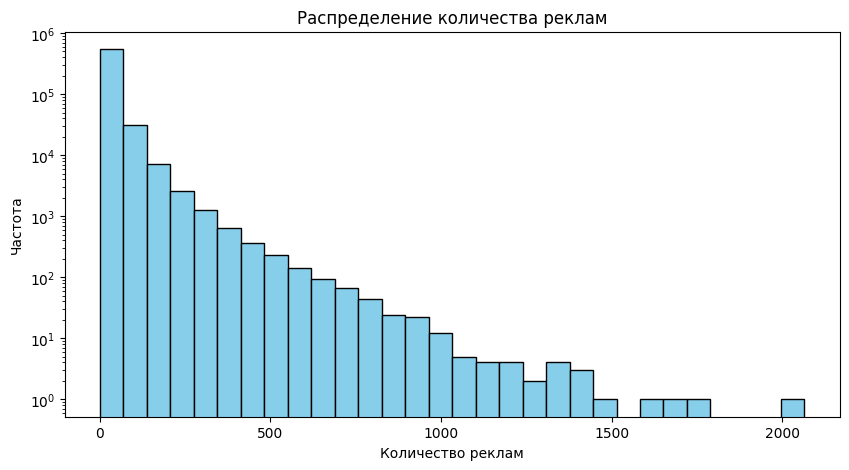

In [147]:
plt.figure(figsize=(10, 5))
plt.hist(df['total ads'], bins=30, color='skyblue', edgecolor='black', log=True) # Применим log=True, т.к. данные имеют большой разброс
plt.title('Распределение количества реклам')
plt.xlabel('Количество реклам')
plt.ylabel('Частота')
plt.show()

1. Гистограмма показывает, что распределение количества реклам распределно **неравномерно**. Большое количество наблюдений сосредоточено в низких значениях графика.

2. Гистограмма напоминает распределение Пуассона или экспоненциальное распределение, где большая часть данных сосредоточена на низких значениях, а частота появления более высоких значений резко падает. Это может указывать на то, что большинство пользователей/наблюдений имеют относительно малое количество рекламы, а немногие — большое количество.

Изобразим box-plot для нашего числового признака:

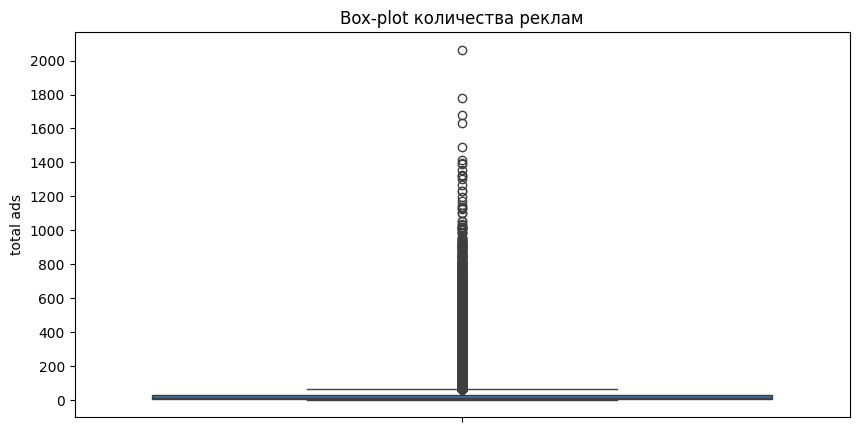

In [148]:
plt.figure(figsize=(10, 5))
sns.boxplot(y=df['total ads'])
plt.title('Box-plot количества реклам')
plt.yticks(range(0, int(df['total ads'].max()) + 1, 200))
plt.show()


#### **Ящик:**
- Обозначает **межквартильный размах (IQR)** — интервал между 25-м и 75-м процентилем.
- Горизонтальная линия внутри ящика — **медиана** (50-й процентиль).
- В данном случае медиана очень близка к нулю (или равна нулю), так как ящик почти прижат к оси X.

#### **Усы:**
- Отражают диапазон данных **без выбросов**.
- Верхний ус заканчивается примерно на значении ~100
- Нижний ус — на нуле (так как минимальное значение = 0).

#### **Выбросы:**
- Здесь видно множество выбросов: от ~150 до ~2100.
- Самый высокий выброс — около **2100**.

### Распределение **очень сильно скошено вправо**:
- Большинство наблюдений — **близки к нулю** (медиана ≈ 40, нижняя граница IQR = 0).
- Но есть **небольшое количество наблюдений с очень большим количеством рекламы** (выбросы до 2100).




### **Категориальные признаки**
Рассмотрим наши категориальные признаки и их распределение

Построим график для признака `test group`.

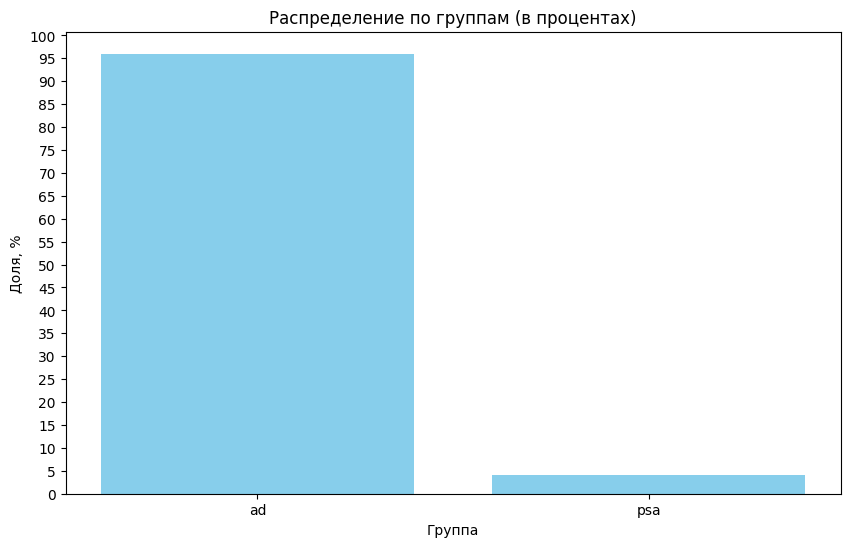

In [149]:
counts = df['test group'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
plt.bar(counts.index, counts, color='skyblue')
plt.title('Распределение по группам (в процентах)')
plt.xlabel('Группа')
plt.ylabel('Доля, %')
plt.yticks(range(0, 101, 5))

plt.show()

По графику можем сделать вывод, что данные имеют неравномерное распределение. Подавляющее большинство относится к группе **ad** (95%), в то время как группа **psa** содержит в себе очень малую долю (около 5%).
____


Построим график для признака `converted`.

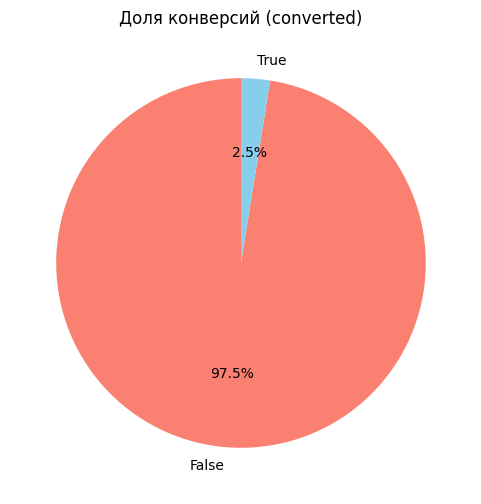

In [150]:
converted_counts = df['converted'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(converted_counts, labels=converted_counts.index, autopct='%1.1f%%', startangle=90, colors=['salmon', 'skyblue'])
plt.title('Доля конверсий (converted)')
plt.show()

По графику можем сделать вывод, что большая часть пользователей **не переходит** по рекламе (97.5%). Оставшиеся пользователи (2.5%) по ней **переходят**.
___


Построим график для признака `most adds day`.

Text(0, 0.5, 'Количество')

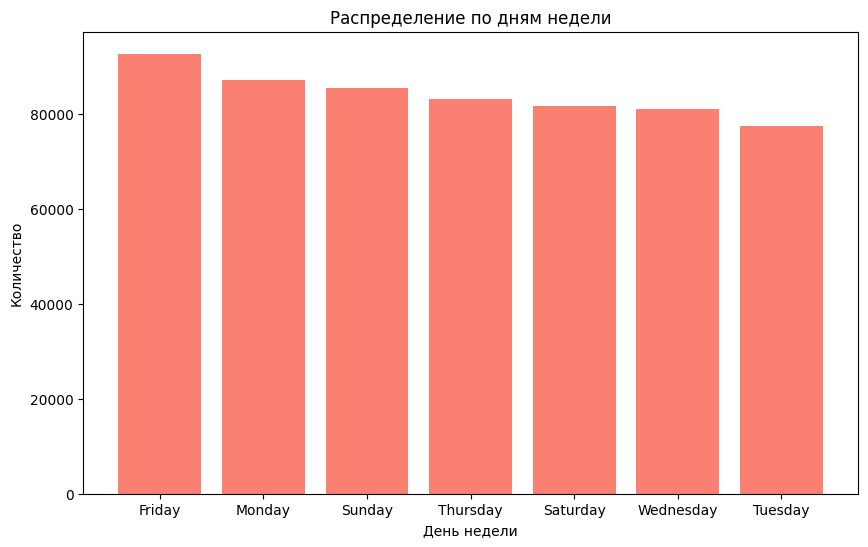

In [151]:
plt.figure(figsize=(10,6))
plt.bar(df['most ads day'].value_counts().index, df['most ads day'].value_counts(), color='salmon')
plt.title('Распределение по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество')

 Пик приходится на **пятницу** (+-90000), а минимум  на **вторник** (+-78000). Из графика мы можем сделать вывод, что уровень в выходные и будные дни примерно одинаковый.
___

Построим график для признака `most adds hour`.


Text(0, 0.5, 'Количество')

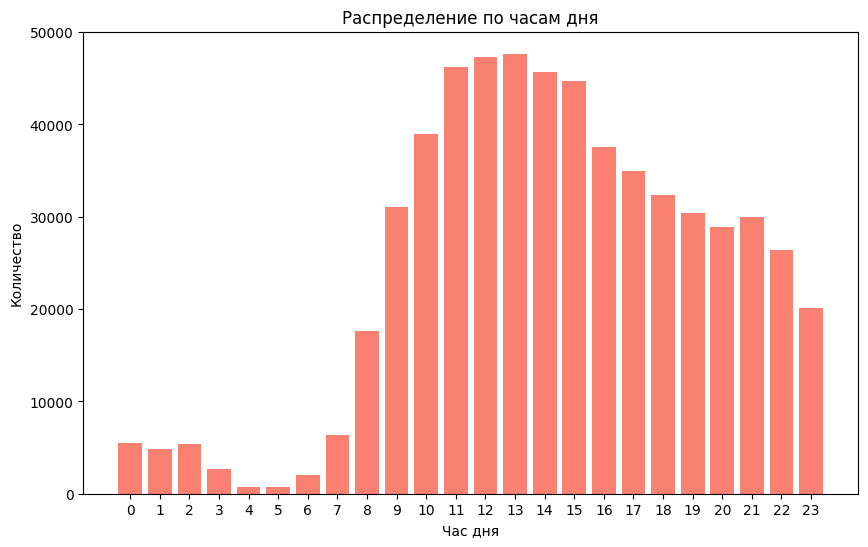

In [152]:
plt.figure(figsize=(10,6))
plt.bar(df['most ads hour'].value_counts().index, df['most ads hour'].value_counts(), color='salmon')
plt.title('Распределение по часам дня')
plt.xlabel('Час дня')
plt.xticks(range(0, 24))
plt.ylabel('Количество')



- **Пик активности** наблюдается в **полдень и после обеда**: самые высокие столбцы приходятся на **12:00 и 13:00** (около 47000 и 48 000 соответственно).
- **Активность начинает расти** с утра: после низкого уровня в ранние часы, она резко увеличивается к **9:00** (~32000) и достигает максимума к полудню.
- **После пика** активность постепенно снижается к вечеру и ночи.
- **Минимальная активность** фиксируется в **ночные часы**: самый низкий уровень — между **4:00 и 5:00** (около 500).

Данные демонстрируют типичную для многих процессов (например, трафика, продаж, посещений сайта) дневную динамику. Активность минимальна в ночное время, растет утром, достигает максимума в середине дня и постепенно снижается вечером. Это указывает на то, что основная деятельность происходит в светлое время суток, особенно в рабочее время.

### **Корреляционный анализ**

Перед тем как проводить корреляционный анализ, проведём некоторые манипуляции над нашими данными.

1. Заменим в столбце `converted` True на 1, False на 0.
2. К столбцу `most ads day` применим One-Hot-Encoding.



In [153]:
df['converted'] = df['converted'].astype(int)

df_dummies = pd.get_dummies(df['most ads day'], prefix='day', dtype=int)

df = pd.concat([df, df_dummies], axis=1)

df.drop('most ads day', axis=1, inplace=True)

In [154]:
df_corr = df[['converted', 'total ads', 'most ads hour', 'day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday','day_Thursday',
              'day_Tuesday','day_Wednesday']]

Строим наши корреляционную матрицу:

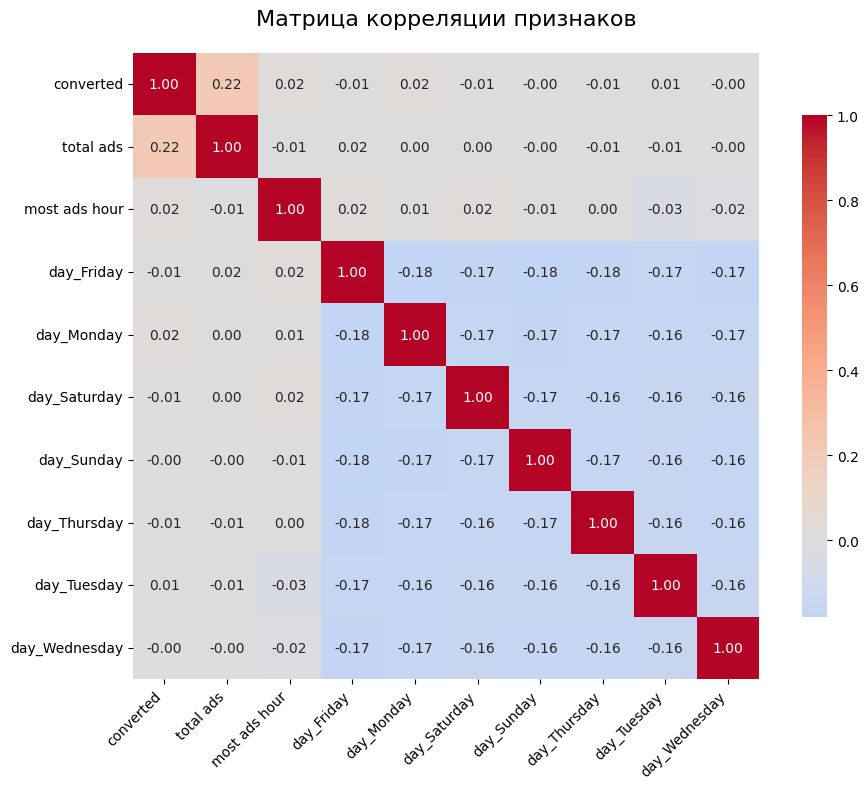

In [155]:
corr_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)

plt.title('Матрица корреляции признаков', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

#### **Связь с конверсией (`converted`)**

*   **`total ads`** (**+0.22**): Это **единственный признак, имеющий хоть какую-то связь** с целевой переменной. Связь слабая, но положительная. Это означает, что пользователи, которые видели больше рекламных объявлений в целом, немного чаще совершают целевое действие (конверсию). Однако сила этой связи низкая.

*   **`most ads hour`** (**+0.02**): Практически **нулевая корреляция**. Конкретный час, в который пользователь видит максимум рекламы, **не влияет** на его склонность к конверсии.

*   **Дни недели** (**от -0.03 до +0.02**): Все коэффициенты находятся в диапазоне, который считается **статистически незначимым**. Это означает, что **день недели не является предиктором** конверсии данных.


Данные показывают, что **единственным слабым фактором, связанным с конверсией, является общее количество показов рекламы (`total ads`)**. Временные признаки в текущем виде **не несут предсказательной силы** для моделирования конверсии.

### **Общий вывод по EDA**



**1. Факторы, влияющие на конверсию:**
Анализ показал, что **единственным выявленным фактором**, слабо связанном с конверсией, является **общее количество показов рекламы (`total ads`)**. Наблюдается слабая положительная корреляция (+0.18), что говорит о том, что пользователи, видевшие больше объявлений, несколько чаще совершают целевое действие. В то же время, **временные характеристики — час наибольшей активности (`most ads hour`) и день недели (`day`) — не демонстрируют статистически значимой связи с конверсией**. Это означает, что время взаимодействия с продуктом (в рамках имеющихся данных) не является предиктором конверсии.

**2. Характер активности пользователей:**
Анализ распределения по времени суток и дням недели показал чёткую дневную активность: пик приходится на дневные и послеобеденные часы (12:00–13:00), а также на будние дни, особенно на **пятницу**. Ночью и в выходные (особенно в субботу) активность минимальна. Это указывает на то, что пользователи преимущественно взаимодействуют с продуктом в рабочее время.

**3. Распределение групп и конверсия:**
В выборке наблюдается крайне **неравномерное распределение между группами тестирования**, где подавляющее большинство пользователей (около 95%) принадлежит к группе `ad`.



## **Обработка данных**

Так как в наших данных есть аномальные выбросы, то нужно их должным образом обработать. Для этого я воспользуюсь методом **IQR (Interquartile Range)** для удаления выбросов.

IQR - разница между 75-ым и 25-ым перцентилем данных:

**IQR = Q3-Q1**

Далее выбросами считаются значения, которые будут лежать за пределами следующего диапазона:

**Нижняя граница = Q1 - 1.5 * IQR**

**Верхняя граница = Q3 + 1.5 * IQR**

Данные, которые лежат за пределами данного интервала могут быть удалены.

In [156]:
def remove_outliers_iqr(df, name):
  Q1 = df[name].quantile(0.25)
  Q3 = df[name].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df = df[(df[name] >= lower_bound) & (df[name] <= upper_bound)]
  return df

In [157]:
df = remove_outliers_iqr(df, 'total ads')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536044 entries, 2 to 588100
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        536044 non-null  int64 
 1   test group     536044 non-null  object
 2   converted      536044 non-null  int64 
 3   total ads      536044 non-null  int64 
 4   most ads hour  536044 non-null  int64 
 5   day_Friday     536044 non-null  int64 
 6   day_Monday     536044 non-null  int64 
 7   day_Saturday   536044 non-null  int64 
 8   day_Sunday     536044 non-null  int64 
 9   day_Thursday   536044 non-null  int64 
 10  day_Tuesday    536044 non-null  int64 
 11  day_Wednesday  536044 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 53.2+ MB


Как мы видим, после **IQR** у нас осталось 536044 наблюдений (до этого было 588100).

## **Гипотеза A/B теста**

#### **Влияет ли новая рекламная стретегия (psa) на конверсию по сравнению со старой (ad)**?

**Гипотеза**: новая рекламная стратегия (psa) прикодит к статистически значимому изменению конверсии по сравнению со старой стратегией (ad).



*  **H₀:** CR_ad = CR_psa
*   **H₁:** CR_ad ≠ CR_psa




## **Определение размера выборки**



Для начала посмотрим на уровень конверсии каждой группы.

In [158]:
conversion_rates = df.groupby('test group')['converted'].mean()

conversion_rates

,converted
test group,
ad,0.013384
psa,0.010596


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536044 entries, 2 to 588100
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        536044 non-null  int64 
 1   test group     536044 non-null  object
 2   converted      536044 non-null  int64 
 3   total ads      536044 non-null  int64 
 4   most ads hour  536044 non-null  int64 
 5   day_Friday     536044 non-null  int64 
 6   day_Monday     536044 non-null  int64 
 7   day_Saturday   536044 non-null  int64 
 8   day_Sunday     536044 non-null  int64 
 9   day_Thursday   536044 non-null  int64 
 10  day_Tuesday    536044 non-null  int64 
 11  day_Wednesday  536044 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 53.2+ MB


In [160]:
df['test group'].value_counts()

,count
test group,
ad,514716
psa,21328


Видим, что для группы `ad` - конверсия составляет **1.33%**.

Для группы с новой рекламной стратегией конверсия составляет - .**1%**.

Определим также следующие переменные:

**Уровень значимости (aplha) = 0.05**

**Вероятность ошибки второго рода (beta) = 0.2**

**Мощность теста (1-beta) = 0.8**

Вычислим размер выборки:

In [161]:
alpha = 0.05
beta = 0.2
power = 1 - beta

p1 = conversion_rates['ad']
p2 = conversion_rates['psa']

effect_size_conversion = sms.proportion_effectsize(p1, p2)
n_conversion = sms.NormalIndPower().solve_power(effect_size=effect_size_conversion, power=power, alpha=alpha, ratio=1)
print(n_conversion)

23849.354905177162


Оптимальное количество данных для обеих групп - **23849**.

Так как в группе `psa` у нас всего  лишь **21328** наблюдений, а рекомендованный размер выборки 23849, то возьмём всю группу psa, а также рандомно отберём 21328 наблюдений из группы `ad`.

In [162]:
test_group = df[df['test group'] == 'psa']
control_group = df[df['test group'] == 'ad'].sample(n=21328, random_state=42)

In [163]:
test_group.info()
print('___________________________________')
control_group.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21328 entries, 38 to 588081
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user id        21328 non-null  int64 
 1   test group     21328 non-null  object
 2   converted      21328 non-null  int64 
 3   total ads      21328 non-null  int64 
 4   most ads hour  21328 non-null  int64 
 5   day_Friday     21328 non-null  int64 
 6   day_Monday     21328 non-null  int64 
 7   day_Saturday   21328 non-null  int64 
 8   day_Sunday     21328 non-null  int64 
 9   day_Thursday   21328 non-null  int64 
 10  day_Tuesday    21328 non-null  int64 
 11  day_Wednesday  21328 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 2.1+ MB
___________________________________
<class 'pandas.core.frame.DataFrame'>
Index: 21328 entries, 328697 to 448941
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user

## **Проведение АА-теста**

А/А тест проведём для того, чтобы проверить корректность системы тестирования и убедиться, что процесс случайного распределения пользователей по группам работает правильно. В этом тесте сравниваются две идентичные группы, и основная цель — выявить, есть ли случайные отклонения между ними. Если такие отклонения присутствуют, это может указывать на проблемы в процессе тестирования, например, на предвзятость в распределении данных. В нашем случае, чтобы убедиться в точности теста перед запуском A/B теста, мы создадим две группы из одной исходной группы.

In [164]:
size = 21328

ad_group = df[df['test group'] == 'ad'].copy()
shuffled_sample = ad_group.sample(n=2 * size, random_state=42)

aa_control_group = shuffled_sample.iloc[:size]
aa_test_group = shuffled_sample.iloc[size:]

Проводим Z-тест:

In [165]:
from statsmodels.stats.proportion import proportions_ztest

control_successes = aa_control_group['converted'].sum()
test_successes = aa_test_group['converted'].sum()

control_size = len(aa_control_group)
test_size = len(aa_test_group)

successes = np.array([control_successes, test_successes])
sizes = np.array([control_size, test_size])

z_stat, p_value = proportions_ztest(successes, sizes, alternative='two-sided')

print(f"Размер AA-control группы: {control_size}")
print(f"Размер AA-test группы: {test_size}")
print(f"Конверсия в AA-control: {control_successes / control_size:.6f}")
print(f"Конверсия в AA-test: {test_successes / test_size:.6f}")
print(f"\nZ-статистика: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print(f"\nВНИМАНИЕ: Обнаружена статистически значимая разница! (p-value = {p_value:.4f})")
else:
    print(f"\nОтлично! Статистически значимой разницы нет (p-value = {p_value:.4f}).")

Размер AA-control группы: 21328
Размер AA-test группы: 21328
Конверсия в AA-control: 0.014347
Конверсия в AA-test: 0.012753

Z-статистика: 1.4239
p-value: 0.1545

Отлично! Статистически значимой разницы нет (p-value = 0.1545).


Как мы видим, **p-value = 0.1545**, следовательно у нас нет статистически значимой разницы между группами, что нам и требовалось!

Построим дополнительно доверительный интервал для нашего результата:

In [169]:
from statsmodels.stats.proportion import confint_proportions_2indep

control_successes = aa_control_group['converted'].sum()
test_successes = aa_test_group['converted'].sum()

control_size = len(aa_control_group)
test_size = len(aa_test_group)

ci_low, ci_upp = confint_proportions_2indep(
    count1=control_successes,
    nobs1=control_size,
    count2=test_successes,
    nobs2=test_size,
    method='newcomb',
    compare='diff'
)

cr_control = control_successes / control_size
cr_test = test_successes / test_size
point_estimate = cr_control - cr_test

print(f"Конверсия в AA-control: {cr_control:.6f}")
print(f"Конверсия в AA-test: {cr_test:.6f}")
print(f"Точечная оценка разницы (CR_control - CR_test): {point_estimate:.6f}")
print(f"95% Доверительный интервал: [{ci_low:.6f}, {ci_upp:.6f}]")

Конверсия в AA-control: 0.014347
Конверсия в AA-test: 0.012753
Точечная оценка разницы (CR_control - CR_test): 0.001594
95% Доверительный интервал: [-0.000604, 0.003799]




**Ключевой вывод: A/A-тест прошел успешно. Система корректна.**

**Доверительный интервал `[-0.000604, 0.003799]` включает ноль.** Это главный критерий успеха.


1.  **Нет доказательств системной ошибки:** Наблюдаемая разница в конверсии (0.16%) **не является статистически значимой**. Она легко может быть объяснена **случайной вариацией** (статистическим шумом).
2.  **Система сплитования работает правильно:** Пользователи были разделены на две группы случайным и несмещенным образом. Никаких технических артефактов или ошибок в распределении не обнаружено.
3.  **Система сбора данных надежна:** Метрика конверсии считается корректно и одинаково для обеих подгрупп.



## **Проведение А/B теста**

У нас уже есть готовые тестовые и контрольные группы, поэтому проведём на их основе наш A/B тест:

In [166]:
control_successes = control_group['converted'].sum()
test_successes = test_group['converted'].sum()

control_size = len(control_group)
test_size = len(test_group)

successes = np.array([control_successes, test_successes])
sizes = np.array([control_size, test_size])

z_stat, p_value = proportions_ztest(successes, sizes, alternative='two-sided')

print(f"Размер AB-control группы: {control_size}")
print(f"Размер AB-test группы: {test_size}")
print(f"Конверсия в AB-control: {control_successes / control_size:.6f}")
print(f"Конверсия в AB-test: {test_successes / test_size:.6f}")
print(f"\nZ-статистика: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print(f"\nВНИМАНИЕ: Обнаружена статистически значимая разница! (p-value = {p_value:.4f})")
else:
    print(f"\nОтлично! Статистически значимой разницы нет (p-value = {p_value:.4f}).")

Размер AB-control группы: 21328
Размер AB-test группы: 21328
Конверсия в AB-control: 0.014347
Конверсия в AB-test: 0.010596

Z-статистика: 3.4903
p-value: 0.0005

ВНИМАНИЕ: Обнаружена статистически значимая разница! (p-value = 0.0005)




**A/B-тест показал статистически значимое (p-value = 0.0005) ухудшение конверсии в тестовой группе (`psa`) по сравнению с контрольной группой (`ad`). Конверсия в группе `psa` ниже на 0.0038 п.п. (абсолютно).**


**Построим доверительный интервал для нашей разницы, чтобы увидеть диапазон, гле лежит истинное значение.**

In [168]:
cr_psa = 0.010596
n_psa = 21328

cr_ad = 0.014347
n_ad = 21328

x_psa = int(cr_psa * n_psa)
x_ad = int(cr_ad * n_ad)

ci_low, ci_upp = confint_proportions_2indep(
    count1=x_psa,
    nobs1=n_psa,
    count2=x_ad,
    nobs2=n_ad,
    method='newcomb',
    compare='diff'
)

point_estimate = cr_psa - cr_ad

print(f"Точечная оценка разницы (CR_psa - CR_ad): {point_estimate:.6f}")
print(f"95% Доверительный интервал: [{ci_low:.6f}, {ci_upp:.6f}]")

Точечная оценка разницы (CR_psa - CR_ad): -0.003751
95% Доверительный интервал: [-0.005869, -0.001650]


По результатам видно, что **95% доверительный интервал** для разницы находится в пределах **[-0.005869, -0.001650]**.

* **Отрицательная разница** (от -0.3751%) указывает на то, что конверсия в группе **psa** меньше, чем в группе **ad**.
* **95% доверительный интервал** означает, что с 95% вероятностью истинная разница в конверсиях между группами находится в пределах от **-0.5869%** до **-0.1650%**. Поскольку этот интервал не включает ноль, можно утверждать, что разница между конверсиями **статистически значима** на уровне значимости 5% (p-value < 0.05).

Таким образом, можно заключить, что **группа ad** имеет значительно лучшую конверсию, чем группа **psa**, с уровнем уверенности 95%.


## **Вывод после проведения A/B теста**

На основании проведённого A/B-теста, в котором в качестве контрольной группы выступала стратегия `ad`, а в качестве тестовой — новая стратегия `psa` (по 21 328 пользователей в каждой), было выявлено статистически значимое ухудшение конверсии. Конверсия в тестовой группе (`psa`) составила 1.06%, что на 0.38 процентных пункта (или на 26.1% относительно) ниже, чем в контрольной группе (`ad`) с конверсией 1.43%. Доверительный интервал для разницы ([-0.0059, -0.0017]) не включает ноль, а p-value (0.0005) значительно ниже порога 0.05, что подтверждает надёжность результата.

**Вывод: новая рекламная стратегия `psa` демонстрирует худшую эффективность по сравнению с текущей стратегией `ad`, и её внедрение не рекомендуется.**